## Particle Swarm Optimizer 
### code from scikit-opt (https://github.com/guofei9987/scikit-opt/tree/master/sko)

In [1]:
import matplotlib.pyplot as plt
import os
from time import strftime,gmtime

from utils import *
from pso import *


In [2]:
overall_path = 'C:/Users/user/project/generate_ev_data/data/overall_pd.csv'
trip_path = 'C:/Users/user/project/generate_ev_data/data/trip_pd.csv'

model = ANN(layers=[3, 4, 8, 16, 8, 4, 1], activation='relu')

checkpoint = torch.load('initial_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint['loss']

In [7]:
def train_pso(
        model : torch.nn.Module,
        loader : DataLoader,
        log_dir : str = 'runs/pso/',
        pop : int = 40,
        epoch : int = 40,
        lb : float = -0.5,
        ub : float = 0.5,
        w : float = 0.85,
        c : list = [1,1,1],
        terminate_threshold : int = 0,
        device : torch.device = 'cpu',
        p_interval : int = 1
        ):
    c1, c2, c3 = c

    model.eval()

    learnable_params = list()
    for p, k in zip(model.parameters(), model.state_dict().keys()):
        if p.requires_grad == True:
            learnable_params.extend(model.state_dict()[k].flatten().tolist())
    state_dicts = model.state_dict()

    inp, tar = next(iter(loader))
    if len(inp) > 50 :
        idx = torch.linspace(0, len(inp)-1, 50, dtype=torch.int64)
        inp = inp[idx]
        tar = tar[idx]
    # tar = tar.flatten().detach().numpy()

    pso = PSO(func=model, n_dim=len(learnable_params), pop=pop,
                max_iter=epoch, lb=lb, ub=ub, w=w, 
                c1=c1, c2=c2, c3=c3, data=(inp,tar), verbose=False, initial_values=learnable_params)
    
    learned_params, best_loss = pso.run(p_interval=p_interval, terminate_threshold=terminate_threshold)

    writer = SummaryWriter(log_dir)
    for idx, i in enumerate(pso.gbest_y_hist):
        writer.add_scalar('train_loss', i, idx)

    idx=0
    for p, k in zip(model.parameters(), model.state_dict().keys()):
        if p.requires_grad == True:
            l = len(p.flatten())
            state_dicts[k] = torch.nn.Parameter(torch.from_numpy(learned_params[idx : idx + l].reshape(p.shape)))
            idx += l
    model.load_state_dict(state_dicts)
    return model, pso

In [8]:
epoch = 300
pop = 300
lb = -0.2
ub = 0.2
w = 0.9
c = [1,1,1]

calibration_threshold = 0.05
terminate_threshold = 0.01
p_interval = 1

log_dir = 'runs/pso/' + strftime("%m%d%H%M", gmtime()) + '/'

In [9]:
v0_model = deepcopy(model)

v_nums = [0]

loss_hist = [[], [], [], []]

v0_model.eval()
model.eval()

# for route_num in range(1, 100):
for route_num in range(13, 20):
    routes = [route_num]
    ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
    train_loader = DataLoader(ev_dataset, batch_size=512, shuffle=False)

    l_0, l_1 = 0, 0
    for inp, tar in train_loader:
        output_ = model(inp)
        
        i_loss = loss(output_, tar)
        l_0 += i_loss.item()

        output_0 = v0_model(inp)
        v0_loss = loss(output_0, tar)
        l_1 += v0_loss.item()
    l_0 /= len(train_loader)
    l_1 /= len(train_loader)
        
    loss_hist[0].append(route_num)
    loss_hist[1].append(l_0)
    loss_hist[2].append(l_1)

    if l_1 > calibration_threshold:
        # st = time.time()
        print(f'model update at route number {route_num}, ', end=' ')
        loss_hist[3].append(route_num)

        v0_model, pso = train_pso(model = v0_model, epoch=epoch, pop=pop, 
                                  loader = train_loader, log_dir= log_dir + str(route_num),
                                  terminate_threshold=terminate_threshold,
                                  p_interval=p_interval, w=w, lb=lb, ub=ub, c=c)
        print('Update complete')
        # print(time.time() - st)
        l_1 = 0
        for inp, tar in train_loader:
            output = v0_model(inp)
            v0_loss = loss(output, tar)
            l_1 += v0_loss.item()
        l_1 /= len(train_loader)

        loss_hist[2][-1] = l_1


print(f'model updated {len(loss_hist[3])} times after initial model')

model update at route number 14,  Update complete
model update at route number 15,  Update complete
model update at route number 17,  Update complete
model update at route number 18,  

KeyboardInterrupt: 

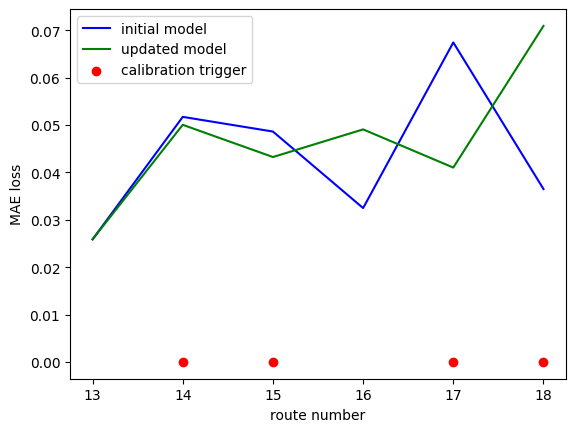

In [10]:
plt.plot(loss_hist[0], loss_hist[1], label = 'initial model', c='b')
plt.plot(loss_hist[0], loss_hist[2], label = 'updated model', c='g')
plt.scatter(loss_hist[3], [0 for _ in loss_hist[3]], label = 'calibration trigger', c='r')
plt.legend()
plt.xlabel('route number')
plt.ylabel('MAE loss')
# plt.savefig('retrain_loss_plot.png')
plt.show()

# torch.save({
#     'epoch' : 100,
#     'model_state_dict' : v0_model.state_dict(),
#     'optimizer_state_dict' : None,
#     'loss' : loss
# }, 'retrained_model.pt')

In [11]:
pso.V

array([[ 5.97769644e+00, -2.24698865e-02,  1.74473620e-01, ...,
         1.72049697e-01,  1.19771769e-01, -4.91588951e-01],
       [ 8.75630804e-03, -2.52923603e-01, -5.63095284e-02, ...,
        -2.75025161e-01,  3.80289707e-02, -2.80402757e-01],
       [ 6.79719985e-01, -7.55225112e-01, -6.76575913e-02, ...,
         1.39485117e+00,  1.82293507e-02,  5.46040061e-03],
       ...,
       [-7.36054522e-01,  4.62329695e-01,  4.97865211e-02, ...,
         7.22878411e-01,  7.94094713e-02,  3.35734489e-01],
       [-2.93114427e-02, -1.02972469e-01, -1.96878088e-01, ...,
         2.44433158e-01,  4.70609832e-02, -7.87859718e-04],
       [-2.26325387e-02, -1.63253890e+00, -1.17916119e-02, ...,
        -9.27420787e-01,  3.01760934e-02, -1.50382707e-01]])

In [12]:
pso.X

array([[ 9.1011056 ,  0.79093858,  0.39957881, ...,  0.23681864,
        -0.81205561, -0.3933174 ],
       [ 1.09514652,  0.94430508,  0.27346416, ..., -0.07380093,
        -0.97933513, -0.08046308],
       [ 0.43798605, -0.26129282,  0.24822038, ...,  0.98995235,
        -0.95148721,  0.19777791],
       ...,
       [ 0.14740411,  0.80547349,  0.21135925, ...,  0.52647317,
        -0.73691898,  1.03356178],
       [-0.21304563,  0.69382866,  0.09596261, ...,  0.24695561,
        -0.15773089,  0.20333186],
       [-0.32116189,  0.30428732,  0.19651096, ..., -0.37851557,
        -0.75742741,  0.28309939]])